# <font color='Red'>Basic two-phase compositional model</font>

First we are going to install open-darts (only need to run it once):

In [54]:
pip install open-darts

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## <font color='blue'>Introduction</font>

#### In the first case study, we cover the basic structures and procedures to run simulation with DARTS. 
#### DARTS contains a main module engine: 
* <font color='red'>engines</font>  
    
#### This module is programmed in C++ and exposed to python with compiled packages (libraries) named as
* <font color='red'>engines.pyd</font>
  
#### The module engines.pyd provides the run-simulation needed functionalities, like
* reservoir (mesh) initialization
* well settings
* interpolation operation
* jacobian assembly
* linear and nonlinear iteration

#### The module engines.pyd can be found in the folder <font color='red'>'darts'</font>.

## <font color='blue'>The objectives for the first exercise</font>
1. Be familiar with the basic procedures to run a simulation
2. Exercise on several simulation parameters including timestep controls and mesh 

## 1D Model can be divided into following parts:
<img style="float: left;" src="slides/Slide4.PNG" width="60%">

## <font color='blue'>Let's start !</font>
### Step 1. We need to import <font color='red'>engines</font> and nessesary physical properties into the workspace, just like the import of commonly-used modules such as numpy etc.

In [55]:
'''Import all important packages from DARTS installation'''
from darts.engines import *
from darts.physics.super.physics import Compositional
from darts.physics.super.property_container import PropertyContainer
from darts.physics.properties.basic import ConstFunc, PhaseRelPerm
from darts.physics.properties.density import DensityBasic
from darts.physics.properties.flash import ConstantK

import numpy as np
import matplotlib.pyplot as plt

### Step 2. We need to specify the time recorder, which could help to make sure about the performance of the simulator in different parts. Timers can be created in hierachical order.

<img style="float: left;" src="slides/Slide6.PNG" width="60%">

In [56]:
'''Activate main timers for simulation'''
def activate_timer():
    # Call class constructor and Build timer_node object
    timer = timer_node()

    # Call object members; there are 2 types of members:
    ## <1>Function member:
    timer.start()
    ## <2>Data member:
    timer.node["simulation"] = timer_node()
    timer.node["initialization"] = timer_node()

    # Start initialization
    timer.node["initialization"].start()
    
    return timer

### Step 3. Simulation parameters setting. Here we specify the simulation parameters, e.g.:

* timestep strategy (first_ts, max_ts, mult_ts)
* convergence criteria (tolerance of nonlinear iteration and other parameters controlling iterations)

<img style="float: left;" src="slides/Slide7.PNG" width="60%">

In [57]:
'''Define main parameters for simulation by overwriting default parameters'''
def define_params(max_ts=1):
    # Build a sim_params object by calling constructor
    params = sim_params()

    # Adjust time step settings
    # First time step (time unit: day)
    params.first_ts = 0.01

    # Time step multiplier
    params.mult_ts = 4

    # Maximum time step
    params.max_ts = max_ts

    # Newton tolerance
    params.tolerance_newton = 1e-10
    
    return params

### Step 4. Mesh initialization
<img style="float: left;" src="slides/Slide8.PNG" width="60%">

<img style="float: left;" src="slides/Slide9.PNG" width="60%">

In [58]:
'''Mesh initialization for 1D reservoir with constant transmissibility'''
def init_mesh(nb):
    # Create mesh object by calling the class constructor
    mesh = conn_mesh()

    # Create connection list for 1D reservoir 
    block_m = np.arange(nb - 1, dtype=np.int32)
    block_p = block_m + 1

    # Set constant transmissbility
    permeability = 2
    tranD = np.ones(nb - 1) * 1e-3 * nb 
    tran = tranD * permeability

    # Initialize mesh with connection list
    mesh.init(index_vector(block_m), index_vector(block_p),
              value_vector(tran), value_vector(tranD))

    # Complete mesh initialization
    mesh.reverse_and_sort()
    
    return mesh

### Step 5. Define reservoir properties
* connecting numpy arrays to the mesh
* fill porosity, depth, volume, conduction and heat capacity
* imitate boundary conditions with large volumes

<img style="float: left;" src="slides/Slide10.PNG" width="60%">

In [59]:
'''Define basic properties for the reservoir'''
def define_reservoir(nb):
    # Create numpy arrays wrapped around mesh data (no copying)
    volume = np.array(mesh.volume, copy=False)
    porosity = np.array(mesh.poro, copy=False)
    depth = np.array(mesh.depth, copy=False)

    # Assign volume, porosity and depth values
    volume.fill(3000 / nb)
    porosity.fill(0.2)
    depth.fill(1000)

    # Make first and last blocks large (source/sink)
    volume[0] = 1e10
    volume[nb-1] = 1e10

### Step 6. Boundary and initial conditions
* initial reservoir conditions
* pressure source and sink
* translation from temperature to enthalpy

<img style="float: left;" src="slides/Slide11.PNG" width="60%">

In [60]:
'''Mimic boundary conditions for the reservoir'''
def define_initial_conditions(nb):
    # Create numpy wrappers for initial solution
    pressure = np.array(mesh.pressure, copy=False) 
    fraction = np.array(mesh.composition, copy=False)

    # Assign initial pressure values
    pressure.fill(200)
    pressure[0] = 250
    pressure[nb-1] = 150

    # Assign molar fraction values
    fraction.fill(0.1)
    fraction[0] = 0.9

### Step 7. Physics initialization
* translate temperature range to enthalpy
* initialize physical ranges

<img style="float: left;" src="slides/Slide12.PNG" width="60%">

In [61]:
'''Create physics from predefined properties from DARTS package'''
def define_physics():
    # basic physical parameters
    zero = 1e-8
    components = ['CO2', 'H2O']
    phases = ['gas', 'oil']
    Mw = [44.01, 18.015]
    
    # activate property container
    property_container = PropertyContainer(phases_name=phases,
                                 components_name=components,
                                 Mw=Mw, min_z=zero/10)

    # properties correlations
    property_container.flash_ev = ConstantK(len(components), [4.0, 0.2], zero)
    property_container.density_ev = dict([('gas', DensityBasic(compr=1e-3, dens0=200)),
                                          ('oil', DensityBasic(compr=1e-5, dens0=600))])
    property_container.viscosity_ev = dict([('gas', ConstFunc(0.05)),
                                            ('oil', ConstFunc(0.5))])
    property_container.rel_perm_ev = dict([('gas', PhaseRelPerm("gas")),
                                           ('oil', PhaseRelPerm("oil"))])

    # Activate physics
    physics = Compositional(components, phases, timer, n_points=200, min_p=100, max_p=300,
                            min_z=zero/10, max_z=1-zero/10)
    physics.add_property_region(property_container)
    physics.init_physics()

    return physics

### Step 8. Engine initialization and run
<img style="float: left;" src="slides/Slide13.PNG" width="60%">

In [62]:
# create all model parameters
nb = 50
timer = activate_timer()
params = define_params(max_ts=1)
mesh = init_mesh(nb)
define_reservoir(nb)
define_initial_conditions(nb)
physics = define_physics()

# Initialize engine
physics.engine.init(mesh, ms_well_vector(),
                    op_vector([physics.acc_flux_itor[0]]),
                    params, timer.node["simulation"])

# Stop initialization timer
timer.node["initialization"].stop()

# Run simulator for 500 days
physics.engine.run(500)

# Print timers (note where most of the time was spent!)
print(timer.print("", ""))

Total elapsed 0.788000 sec
	initialization 0.013000 sec
	simulation 0.775000 sec
		jacobian assembly 0.538000 sec
			interpolation 0.525000 sec
				property interpolation 0.000000 sec
				reservoir 0 interpolation 0.527000 sec
					body generation 0.512000 sec
						point generation 0.504000 sec
				well controls interpolation 0.000000 sec
				wellbore interpolation 0.000000 sec
		linear solver setup 0.000000 sec
			SUPERLU 0.000000 sec
		linear solver solve 0.038000 sec
			SUPERLU 0.034000 sec
		newton update 0.000000 sec
			composition correction 0.000000 sec



### Step 9. Data processing and plots

<img style="float: left;" src="slides/Slide14.PNG" width="60%">

In [63]:
# Define function to plot data profiles
%matplotlib inline
def plot_profile(data, name, sp, ax):
    n = len(data)    
    ax.plot(np.arange(n), data[0:n], '-')
    ax.set_xlabel('Grid index')
    ax.set_ylabel('%s' % (name))

<Figure size 432x288 with 0 Axes>

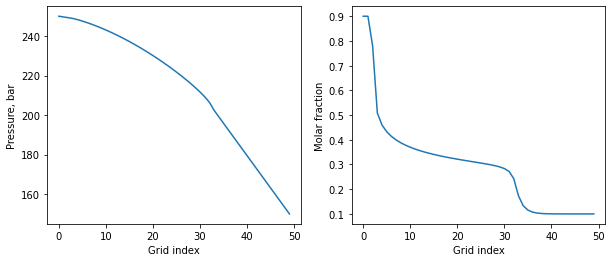

In [64]:
# Get numpy wrapper for final solution
X = np.array(physics.engine.X, copy=False)

# Prepare for plotting
fig = plt.figure()   

nc = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plot pressure profile
plot_profile(X[0:nc*nb:nc],'Pressure, bar', 1, axes[0])
# Plot molar fraction profile
plot_profile(X[1:nc*nb:nc],'Molar fraction', 2, axes[1])